# Data science analysis: Deep  neural network modeling  with Keras

**Notebook by Christian Contreras-Campana, PhD**

Lab-notebook (not yet deliverable-notebook)

## Introduction

Developing a data analytic report scheme for ttH(bb) multivariate analysis study using machine larning technologies.

The columns in the file are:
- mass_tag_tag_min_deltaR: Mass for b-tag jet pair with minimum $\Delta$R
- median_mass_jet_jet: Median invariant mass of all combinations of jet pairs
- maxDeltaEta_tag_tag:  The $\Delta\eta$ between the two furthest b-tagged jets
- mass_higgsLikeDijet:  The invariant mass of a jet pair ordered in closeness to a Higgs mass
- HT_tags: Scalar sum of transverse momentum for all jets
- btagDiscriminatorAverage_tagged:  Average CSV b-tag discriminant value for b-tagged jets
- mass_jet_tag_min_deltaR:  Invariant mass of jet pair (with at least one b-tagged) $\Delta$R
- mass_jet_jet_min_deltaR:  Invariant mass of jet pair $\Delta$R
- mass_tag_tag_max_mass:  Mass for b-tagged jet pair with maximum invariant mass combination
- centrality_jets_leps:  The ratio of the sum of the transverse momentum of all jets and leptons
- maxDeltaEta_jet_jet:  Invariant mass of jet pair DR
- centrality_tags:  The ratio of the sum of the transverse momentum of all b-tagged jets

While we have some grasp on the matter, we're not experts, so the following might contain inaccuracies or even outright errors. Feel free to point them out, either in the comments or privately.

## Load Libraries

We load all the necessary python libraries that will permit us to load the data files, pre-process and clean the data, perform data validation, produce statistical summaries, conduct exploratory data analysis, as well as feature transformation, feature ranking, and feature selection. Python libraries will also be needed for model selection, evaluating overfitting, executing standard nested k-fold cross validation for hyper-parameter optimization and model evaluation.  

In [32]:
## Import common python libraries
import sys
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Import from root_numpy library
import root_numpy
from root_numpy import root2array, rec2array

# Import panda library
from pandas.tools import plotting
from pandas.tools.plotting import scatter_matrix
from pandas.core.index import Index
import pandas.core.common as com

# Import scipy
import scipy
from scipy.stats import ks_2samp
import scipy as sp

# Import itertools
import itertools
from itertools import cycle

# Import Jupyter
from IPython.core.interactiveshell import InteractiveShell

# Import scikit-learn
import sklearn
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RandomizedLasso

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.feature_selection import RFECV
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import (confusion_matrix, roc_auc_score, roc_curve, 
                             auc, average_precision_score, precision_score, 
                             brier_score_loss, recall_score, f1_score, log_loss, 
                             classification_report, precision_recall_curve)
from sklearn.dummy import DummyClassifier

from sklearn.externals import joblib
from sklearn import feature_selection


## Keras deep neural network library
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import WeightRegularizer, l1, l2
from keras.models import model_from_json

# Plotting Variables and Correlations 
import pandas.core.common as com
from pandas.core.index import Index

# Import imblearn
import imblearn
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from collections import defaultdict, Counter

import re

# Print version information of some packages
print("Python version " + sys.version)
print("Sklearn version " + sklearn.__version__)
print("Root_numpy version " + root_numpy.__version__)
print("Numpy version " + np.__version__)
print("Scipy version " + scipy.__version__)
print("Pandas version " + pd.__version__)
print("Matplotlib version " + matplotlib.__version__)
print("Seaborn version " + sns.__version__)
print("Imblance version " +imblearn.__version__)

# Fix random seed for reproducibility
seed = 7
np.random.seed(seed)

%matplotlib inline

# Specifying which nodes should be run interactively
InteractiveShell.ast_node_interactivity = "all"
print(__doc__)

Python version 2.7.12 (default, Oct 11 2016, 05:16:02) 
[GCC 4.2.1 Compatible Apple LLVM 7.0.2 (clang-700.1.81)]
Sklearn version 0.19.dev0
Root_numpy version 4.6.0.dev0
Numpy version 1.12.0.dev0+6bb5a22
Scipy version 0.18.1
Pandas version 0.17.1
Matplotlib version 1.5.3
Seaborn version 0.8.dev
Imblance version 0.2.1
Automatically created module for IPython interactive environment


## Load Data Files

Most data files contain approximately 15K events. There are a total of 4 files totaling 80K data events. We list the features and response names. We store the data in a Pandas DataFrame for greater ease of data manipulation.

**Note: To reduce running time of the program we use our most signal-like category which is statistically limited**

In [33]:
## Define data load function

def load(sig_filename, bkg_filename, category, features):
    """Multi class version of Logarithmic Loss metric.
    https://www.kaggle.com/wiki/MultiClassLogLoss

    Parameters
    ----------
    sig_filename : array, shape = [n_samples]
            true class, intergers in [0, n_classes - 1)
    bkg_filename : array, shape = [n_samples, n_classes]
    category: string
    features: array, shape = [n_features]

    Returns
    -------
    data : pandas.DataFrame
    """

    signal = root2array(sig_filename, category, features)
    signal = rec2array(signal)

    backgr = root2array(bkg_filename, category, features)
    backgr = rec2array(backgr)

    # for sklearn data is usually organised
    # into one 2D array of shape (n_samples x n_features)
    # containing all the data and one array of categories
    # of length n_samples
    X = np.concatenate((signal, backgr))
    y = np.concatenate((np.ones(signal.shape[0]), np.zeros(backgr.shape[0])))

    # convert to numpy ndarray into pandas dataframe
    dataframe_X = pd.DataFrame(data=X, columns=features)
    dataframe_y = pd.DataFrame(data=y, columns=['y'])

    data = pd.concat([dataframe_X, dataframe_y], axis=1)

    return data

In [34]:
## Load data files

# Feature names
branch_names = """mass_tag_tag_min_deltaR,median_mass_jet_jet,
    maxDeltaEta_tag_tag,mass_higgsLikeDijet,HT_tags,
    btagDiscriminatorAverage_tagged,mass_jet_tag_min_deltaR,
    mass_jet_jet_min_deltaR,mass_tag_tag_max_mass,maxDeltaEta_jet_jet,
    centrality_jets_leps,centrality_tags""".split(",")

features = [c.strip() for c in branch_names]
features = (b.replace(" ", "_") for b in features)
features = list(b.replace("-", "_") for b in features)

wall = time.time()
process = time.clock()

# Load dataset
signal_sample = "combined/signalData.root"
background_sample = "combined/backgroundData.root"
tree_category = "event_mvaVariables_step7_cate4"

data = load(signal_sample, background_sample, tree_category, features)

print "Total number of events: {}\nNumber of features: {}".format(data.shape[0], data.shape[1])

# Store a copy for later use
df_archived = data.copy(deep=True)

print "\nWall time to read in file input: ", time.time()-wall
print "Elapsed time to read in file input: ", time.clock()-process

Total number of events: 11367
Number of features: 13

Wall time to read in file input:  0.131768941879
Elapsed time to read in file input:  0.0714070000004


In [35]:
## Print statistical summary of dataset

# To print out all rows and columns to the terminal
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

wall = time.time()
process = time.clock()

print "Head:"
data.head()
print "Information:" 
data.info()
print "Describe:"
data.describe()

print "\nWall time to print statistical summary: ", time.time()-wall
print "Elapsed time to print statistical summary: ", time.clock()-process

Head:


,mass_tag_tag_min_deltaR,median_mass_jet_jet,maxDeltaEta_tag_tag,mass_higgsLikeDijet,HT_tags,btagDiscriminatorAverage_tagged,mass_jet_tag_min_deltaR,mass_jet_jet_min_deltaR,mass_tag_tag_max_mass,maxDeltaEta_jet_jet,centrality_jets_leps,centrality_tags,y
0,147.603592,130.981232,0.687603,122.511047,538.873779,0.930030,70.437866,70.437866,340.378510,3.860818,0.428346,0.498534,1
1,108.581604,77.832825,0.864248,135.179031,337.303406,0.950204,41.930336,41.930336,108.581604,3.070951,0.622397,0.816231,1
2,105.616219,105.616219,1.058237,120.094742,316.633179,0.982161,105.616219,105.616219,179.836838,3.676557,0.557839,0.812467,1
3,95.862236,160.030258,1.064351,123.404343,795.236816,0.947199,95.862236,95.862236,395.256042,1.817336,0.771404,0.925250,1
4,47.023891,102.159294,0.745558,108.855278,340.840973,0.937956,47.023891,47.023891,200.242111,1.285695,0.899807,0.971952,1


Information:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11367 entries, 0 to 11366
Data columns (total 13 columns):
mass_tag_tag_min_deltaR            11367 non-null float32
median_mass_jet_jet                11367 non-null float32
maxDeltaEta_tag_tag                11367 non-null float32
mass_higgsLikeDijet                11367 non-null float32
HT_tags                            11367 non-null float32
btagDiscriminatorAverage_tagged    11367 non-null float32
mass_jet_tag_min_deltaR            11367 non-null float32
mass_jet_jet_min_deltaR            11367 non-null float32
mass_tag_tag_max_mass              11367 non-null float32
maxDeltaEta_jet_jet                11367 non-null float32
centrality_jets_leps               11367 non-null float32
centrality_tags                    11367 non-null float32
y                                  11367 non-null float64
dtypes: float32(12), float64(1)
memory usage: 710.4 KB
Describe:


,mass_tag_tag_min_deltaR,median_mass_jet_jet,maxDeltaEta_tag_tag,mass_higgsLikeDijet,HT_tags,btagDiscriminatorAverage_tagged,mass_jet_tag_min_deltaR,mass_jet_jet_min_deltaR,mass_tag_tag_max_mass,maxDeltaEta_jet_jet,centrality_jets_leps,centrality_tags,y
count,11367.000000,11367.000000,11367.000000,11367.000000,11367.000000,11367.000000,11367.000000,11367.000000,11367.000000,11367.000000,11367.000000,11367.000000,11367.000000
mean,72.798241,130.862808,1.997350,123.515701,330.864532,0.953809,59.250546,57.884563,277.801971,2.544357,0.612226,0.645179,0.407759
std,44.720844,53.332294,0.853301,12.729280,148.476593,0.022853,35.247810,34.503632,167.021317,0.933684,0.140469,0.165729,0.491440
min,12.827889,34.870777,0.056909,32.053608,106.264732,0.862530,12.739735,12.739735,44.457249,0.056909,0.231664,0.212124,0.000000
25%,41.457064,95.139206,1.349514,118.144566,230.644905,0.938563,34.269251,33.438381,166.857140,1.838349,0.506289,0.517949,0.000000
50%,61.499058,119.706558,1.911217,124.262650,296.524689,0.955676,49.405842,48.320328,234.538193,2.529104,0.610159,0.652854,0.000000
75%,94.490131,153.664055,2.571308,129.121353,389.422974,0.970845,74.023079,72.219364,337.147400,3.226846,0.716640,0.777259,1.000000
max,936.203491,598.427429,4.743262,283.593201,2469.952637,0.998742,467.599091,467.599091,2658.857422,4.773415,0.959233,0.989606,1.000000



Wall time to print statistical summary:  0.195977926254
Elapsed time to print statistical summary:  0.17105


In [36]:
## Define class label counts and percentages

def class_info(classes):
    # Store the number of signal and background events
    class_count = {}
    counts = Counter(classes)
    total = sum(counts.values())

    for cls in counts.keys():
        class_count[class_label[cls]] = counts[cls]
        print("%6s: % 7d  =  % 5.1f%%" 
              % (class_label[cls], counts[cls], float(counts[cls])/float((total))*100.0))

    return (class_count["signal"], class_count["background"])

In [37]:
# Determine class label counts and percentages
class_label = {0.0: "background", 1.0: "signal"}
class_info(data["y"]);

background:    6732  =   59.2%
signal:    4635  =   40.8%


In [38]:
## Create features dataframe and target array

df_X = data.drop("y", axis=1, inplace=False)
df_y = data["y"]

In [39]:
# Create network with Keras: Function to create model, 
# required for KerasClassifier (model architecture)

def create_model(optimizer='rmsprop', init='glorot_uniform', dropout_rate=0.0):
    """Multi class version of Logarithmic Loss metric.

    Parameters
    ----------
    y_true : array, shape = [n_samples]
            true class, intergers in [0, n_classes - 1)
    y_pred : array, shape = [n_samples, n_classes]

    Returns
    -------
    loss : float
    """
    
    # create model: create a simple multi-layer neural network for the problem.

    # Note: initialization of the weights was chose as default to be 
    # randomly drawn from a uniform distribution (if normal then the distribution
    # would have mean 0 and standard deviation 0.05 in keras)

    # expected input data shape: (batch_size, timesteps, data_dim)
    model = Sequential()
    # Rectify Linear Unit (Relu) = relu, Exponential Linear Unit (Elu) =  elu
    model.add(Dense(12, input_dim=12, init=init, activation='elu')) 
    # ReLu(x) = {0 for x <=0 else x for x > 0}
    model.add(Dropout(dropout_rate))
     # 8 neurons in the hidden layer and 12 in the visible layer 
    model.add(Dense(8, init=init, activation='elu')) # 8 neurons in the hidden layer 
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, init=init, activation='sigmoid')) # 1 neuron in the output layer

    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [40]:
# preprocessing using 0-1 scaling byremoving the mean and scaling to unit variance 
scaler = RobustScaler()

# create classifier for use in scikit-learn
model = KerasClassifier(build_fn=create_model, nb_epoch=50, batch_size=3, verbose=0)

pipe_classifiers = {
    'SVM':  make_pipeline(scaler, SVC()),
    'NB' :  make_pipeline(scaler, GaussianNB()), 
    'MLP':  make_pipeline(scaler, MLPClassifier()),
    'LR' :  make_pipeline(scaler, LogisticRegression()),
    'ADA':  make_pipeline(None,   AdaBoostClassifier()),
    'KNN':  make_pipeline(scaler, KNeighborsClassifier()),
    'RFC':  make_pipeline(None,   RandomForestClassifier()),
    'CART': make_pipeline(None,   DecisionTreeClassifier(min_samples_leaf=10)),
    'LDA':  make_pipeline(scaler, LinearDiscriminantAnalysis()),
    'GRAD': make_pipeline(None,   GradientBoostingClassifier()),
    'BAGG': make_pipeline(None,   BaggingClassifier()),
    'DNN':  make_pipeline(scaler, model)
}

In [41]:
## Compute ROC curve and area under the curve

def roc_plot(models, X, y):
    """Multi class version of Logarithmic Loss metric.
    https://www.kaggle.com/wiki/MultiClassLogLoss

    Parameters
    ----------
    models : dictionary, shape = [n_models]
    X : DataFrame, shape = [n_samples, n_classes]
    y : DataFrame, shape = [n_classes]

    Returns
    -------
    roc : matplotlib plot
    """
     
    # Split data into a development and evaluation set
    X_dev,X_eval, y_dev,y_eval = train_test_split(X, y, test_size=0.33, random_state=42)
    # Split development set into a train and test set
    X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, 
                                                        test_size=0.33, random_state=seed)
    
    # contains rates for ML classifiers
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    # Customize the major grid
    fig, ax = plt.subplots()
    ax.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    ax.set_axis_bgcolor('white')
    
    # Include random by chance 'luck' curve
    plt.plot([1, 0], [0, 1], '--', color=(0.1, 0.1, 0.1), label='Luck')
        
    # Loop through classifiers
    for (name, model) in models.items():
        
        print "\n\x1b[1;31mBuilding model ...\x1b[0m"
        process = time.clock()
        model.fit(X_train, y_train)

        print "\t%s fit time: %.3f"%(name, time.clock()-process)
        
        y_predicted = model.predict(X_test)
        
        if hasattr(model, "predict_proba"):
            decisions = model.predict_proba(X_test)[:, 1]
        else:  # use decision function
            decisions = model.decision_function(X_test)
        
        print "\tArea under ROC curve for %s: %.4f"%(name, roc_auc_score(y_test,decisions))
        
        process = time.clock()
        #scores = cross_val_score(model, X_test, y_test, scoring="roc_auc",
        #                         n_jobs=1, cv=3) #n_jobs=-1
        #print "\tAUC ROC accuracy: %0.5f (+/- %0.5f)"%(scores.mean(), scores.std())
        #print "\tDuration of cross-validation score: ", time.clock()-process

        print classification_report(y_test, y_predicted, target_names=['signal', 'background'])
        print("\tScore of test dataset: {:.5f}".format(model.score(X_test, y_test)))
        
        process = time.clock()
        fpr[name], tpr[name], thresholds = roc_curve(y_test, decisions)
        print "\tArea under ROC time: ", time.clock()-process
        
        roc_auc[name] = auc(fpr[name], tpr[name])
    
    # color choices: https://css-tricks.com/snippets/css/named-colors-and-hex-equivalents/
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 
                    'green', 'yellow', 'SlateBlue', 'DarkSlateGrey',
                    'CadetBlue', 'Chocolate', 'darkred', 'GoldenRod'])
  
    for (name, model), color in zip(models.items(), colors):

        plt.plot(tpr[name], 1-fpr[name], color=color, lw=2,
                 label='%s (AUC = %0.3f)'%(name, roc_auc[name]))                 
    
    # Plot all ROC curves
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("Receiver operating characteristic ({} events)".format(X.shape[0]))
    leg = plt.legend(loc="lower left", frameon=True, fancybox=True, fontsize=8) # loc='best'
    leg.get_frame().set_edgecolor('w')
    frame = leg.get_frame()
    frame.set_facecolor('White')
    
    return plt.show()


Building model ...
	KNN fit time: 0.016
	Area under ROC curve for KNN: 0.6670
             precision    recall  f1-score   support

     signal       0.69      0.74      0.71      1494
 background       0.57      0.51      0.54      1019

avg / total       0.64      0.65      0.64      2513

	Score of test dataset: 0.64783
	Area under ROC time:  0.00166700000045

Building model ...
	SVM fit time: 0.976
	Area under ROC curve for SVM: 0.7317
             precision    recall  f1-score   support

     signal       0.71      0.83      0.76      1494
 background       0.67      0.49      0.57      1019

avg / total       0.69      0.69      0.68      2513

	Score of test dataset: 0.69359
	Area under ROC time:  0.00112700000045

Building model ...
	DNN fit time: 373.746
	Area under ROC curve for DNN: 0.7383
             precision    recall  f1-score   support

     signal       0.71      0.80      0.76      1494
 background       0.65      0.53      0.58      1019

avg / total       0.69    

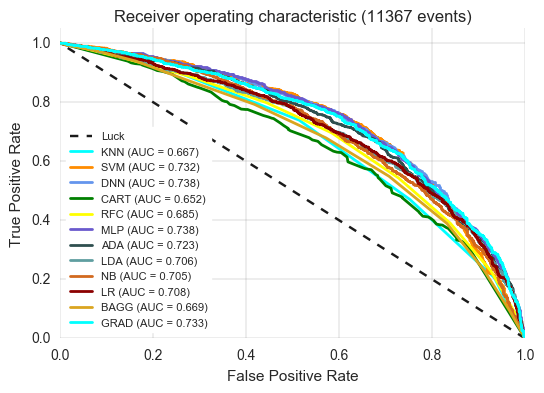


Wall time to generate ROC curves:  263.988529205
Elapsed time to generate ROC curves:  383.109688


In [42]:
# Plot ROC curve

wall = time.time()
process = time.clock()

# Assessing a Classifier's Performance
roc_plot(pipe_classifiers, df_X, df_y)
                   
print "\nWall time to generate ROC curves: ", time.time()-wall
print "Elapsed time to generate ROC curves: ", time.clock()-process

In [43]:
## Define calibration curve (reliability curve)

def plot_calibration_curve(est, X, y, fig_index):
    """Plot calibration curve for est w/o and with calibration. """

    # Split data into a development and evaluation set
    X_dev,X_eval, y_dev,y_eval = train_test_split(X, y,
                                                  test_size=0.33, random_state=42)
    # Split development set into a train and test set
    X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.33,
                                                        random_state=seed)
    
    name = est.steps[1][0]
    
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # We take the no calibration as baseline
    fig = plt.figure(fig_index, figsize=(6, 6))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "--", label="Perfectly calibrated")
    
    for clf, name in [(est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]: # Also called Platt Scaling
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        print("\n\x1b[1;31mclassifier %s:\x1b[0m" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "o-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots (reliability curve)')
 
    # Customize the major grid
    ax1.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    ax1.set_axis_bgcolor('white')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="best", ncol=1)
    
    # Customize the major grid
    ax2.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    ax2.set_axis_bgcolor('white')
    
    plt.tight_layout()
    plt.show()


classifier kerasclassifier:
	Brier: 0.204
	Precision: 0.655
	Recall: 0.511
	F1: 0.574


classifier kerasclassifier + Isotonic:
	Brier: 0.204
	Precision: 0.640
	Recall: 0.520
	F1: 0.574


classifier kerasclassifier + Sigmoid:
	Brier: 0.203
	Precision: 0.662
	Recall: 0.528
	F1: 0.587



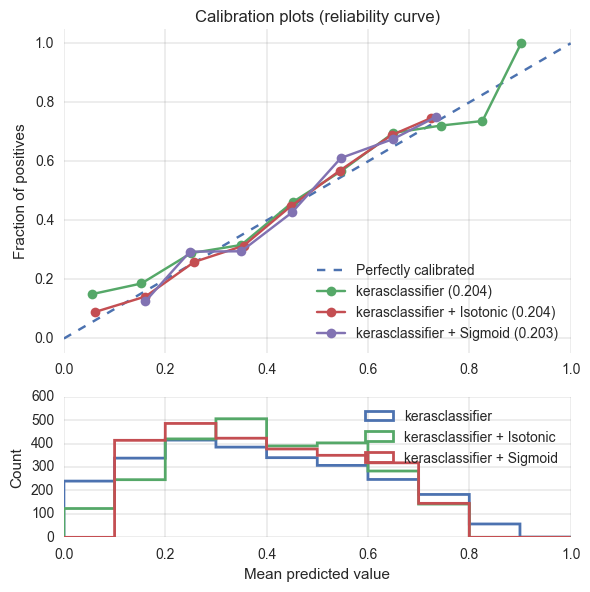


Wall time to generate Calibration curves:  655.176646948
Elapsed time to generate Calibration curves:  980.753829


In [46]:
## Plot reliability curve (i.e. calibration curve)

wall = time.time()
process = time.clock()

#plot_calibration_curve(make_pipeline(None, model), df_X, df_y, 2)
plot_calibration_curve(pipe_classifiers["DNN"], df_X, df_y, 2)

print "\nWall time to generate Calibration curves: ", time.time()-wall
print "Elapsed time to generate Calibration curves: ", time.clock()-process

In [47]:
## Defined overfitting plot

def compare_train_test(clf, X, y, bins=30):
    """Multi class version of Logarithmic Loss metric.

    Parameters
    ----------
    y_true : array, shape = [n_samples]
            true class, intergers in [0, n_classes - 1)
    y_pred : array, shape = [n_samples, n_classes]

    Returns
    -------
    loss : float
    """
    
    # Split data into a development and evaluation set
    X_dev,X_eval, y_dev,y_eval = train_test_split(X, y, test_size=0.33, random_state=42)
    # Split development set into a train and test set
    X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, 
                                                        test_size=0.33, random_state=seed)
    
    # use subplot to extract axis to add ks and p-value to plot
    fig, ax = plt.subplots()
    
    # Customize the major grid
    ax.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    ax.set_axis_bgcolor('white')
    
    decisions = []
    for X, y in ((X_train, y_train), (X_test, y_test)):

        if hasattr(clf,"decision_function"):
            d1 = clf.decision_function(X[y>0.5]).ravel()
            d2 = clf.decision_function(X[y<0.5]).ravel()
        else:
            d1 = clf.predict_proba(X[y>0.5])[:, 1]
            d2 = clf.predict_proba(X[y<0.5])[:, 1]
        
        decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
    
    plt.hist(decisions[0],
             color='r', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', normed=True,
             label='signal (train)')
    plt.hist(decisions[1],
             color='b', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', normed=True,
             label='background (train)')
    
    hist, bins = np.histogram(decisions[2],
                              bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='signal (test)')
    
    hist, bins = np.histogram(decisions[3],
                              bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='background (test)')
    
    # Define signal and background histograms for training & testing 
    hist_sig_train, bins = np.histogram(decisions[0], bins=bins, range=low_high, normed=True)
    hist_bkg_train, bins = np.histogram(decisions[1], bins=bins, range=low_high, normed=True)
    
    hist_sig_test, bins = np.histogram(decisions[2], bins=bins, range=low_high, normed=True)
    hist_bkg_test, bins = np.histogram(decisions[3], bins=bins, range=low_high, normed=True)
    
    # Estimate ks-test and p-values as an indicator of overtraining of fit model
    s_ks, s_pv = ks_2samp(hist_sig_train, hist_sig_test)
    b_ks, b_pv = ks_2samp(hist_bkg_train, hist_bkg_test)
    
    if hasattr(clf, "steps"):
        name = clf.steps[1][0]
    else:
        name = clf.__class__.__name__
    
    ax.set_title("Classifier: %s\nsignal(background) ks: %f(%f), p-value: %f (%f)" 
                 % (name, s_ks, b_ks, s_pv, b_pv))

    plt.xlabel("Decision output")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')
    
    return plt.show()

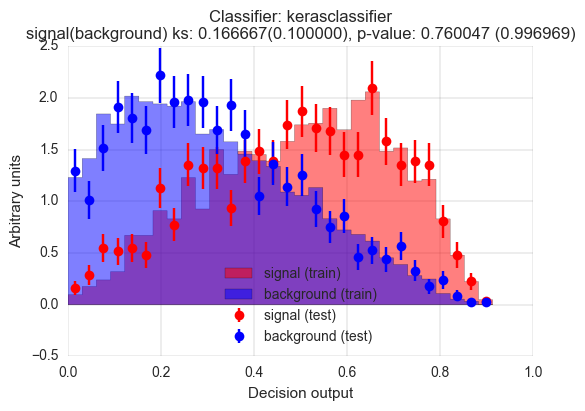


Wall time to generate over-training plots:  1.99943685532
Elapsed time to generate over-training plots:  2.410018


In [48]:
## Overfitting evaluation

wall = time.time()
process = time.clock()

# Uncalibrated model predictions
compare_train_test(pipe_classifiers["DNN"], df_X, df_y, bins=30)

print "\nWall time to generate over-training plots: ", time.time()-wall
print "Elapsed time to generate over-training plots: ", time.clock()-process

In [30]:
## Visualize weights: Heat Map of neural network weights

# Heat map of the first layer weights in a neural network learned on the HEP dataset
# Source: http://share.pkbigdata.com/ID.16719/CAPTCHA-breaking/src/master/keras-master/tests/manual/check_wrappers.py

# Get the neural network weights
# TensorFlow based weight object (for Theano use a different code syntax)

def dnn_weight_map(classifier):
    
    #W,b = pcv.best_estimator_.named_steps['classifier'].model.layers[0].get_weights()
    W,b = classifier.model.layers[0].get_weights()

    W = np.squeeze(W)
    print("W shape : ", W.shape)

    _= plt.figure(figsize=(10, 8))
    _= plt.imshow(W, interpolation='nearest', cmap='viridis')

    # Heat map
    _= plt.yticks(range(12), features)
    _= plt.xlabel("Columns in weight matrix")
    _= plt.ylabel("Input feature")
    _= plt.colorbar()
    _= plt.grid("off")
    
    return plt.show()
    

('W shape : ', (12, 12))


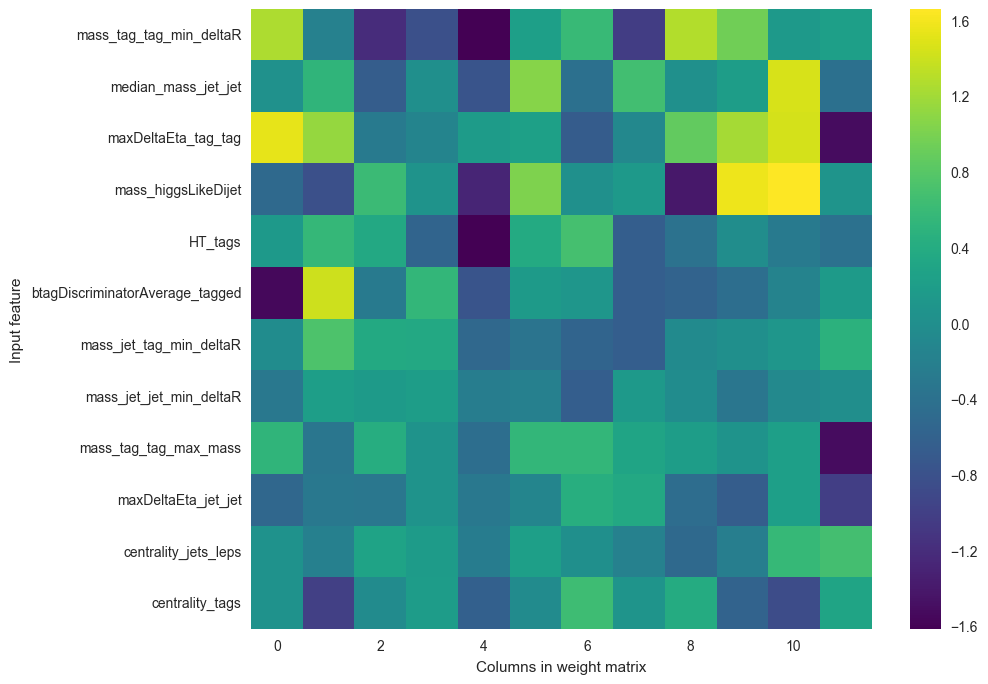

In [49]:
## Visualize weights: Heat Map of neural network weights

dnn_weight_map( pipe_classifiers["DNN"].named_steps['kerasclassifier'])

In [50]:
# Load dataset
rec_np_data = root2array("combined/run2016Data.root", 
                         "event_mvaVariables_step7_cate4", features)
np_data = rec2array(rec_np_data)


# convert to numpy ndarray into pandas dataframe
df_raw_data = pd.DataFrame(data=np_data, columns=features)

df_raw_data.describe()
df_raw_data.info()

X_data = df_raw_data.values

,mass_tag_tag_min_deltaR,median_mass_jet_jet,maxDeltaEta_tag_tag,mass_higgsLikeDijet,HT_tags,btagDiscriminatorAverage_tagged,mass_jet_tag_min_deltaR,mass_jet_jet_min_deltaR,mass_tag_tag_max_mass,maxDeltaEta_jet_jet,centrality_jets_leps,centrality_tags
count,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000
mean,70.616943,129.194855,2.244591,122.657669,314.463989,0.933510,56.595409,55.073750,294.483398,2.738583,0.587393,0.605538
std,46.079117,50.489464,0.935588,14.190564,152.232407,0.031298,36.162693,34.590950,205.816559,0.931405,0.134934,0.164553
min,21.882309,44.966316,0.251038,70.595703,121.009186,0.842857,18.422209,18.725286,86.632751,0.325770,0.339148,0.261750
25%,40.891049,95.306015,1.664153,117.953224,214.759674,0.910842,32.319913,31.934588,163.397522,2.180021,0.481309,0.467066
50%,57.879677,122.436413,2.274248,123.650925,273.518265,0.937316,45.549355,44.664923,230.998512,2.669810,0.575037,0.610401
75%,85.258221,150.377941,2.933737,129.782356,382.471153,0.957647,62.570323,61.612444,372.370338,3.539405,0.689788,0.737645
max,316.895203,316.895203,4.435757,161.764435,1302.223755,0.992546,251.595108,251.595108,1717.021606,4.704609,0.942698,0.942889


<class 'pandas.core.frame.DataFrame'>
Int64Index: 146 entries, 0 to 145
Data columns (total 12 columns):
mass_tag_tag_min_deltaR            146 non-null float32
median_mass_jet_jet                146 non-null float32
maxDeltaEta_tag_tag                146 non-null float32
mass_higgsLikeDijet                146 non-null float32
HT_tags                            146 non-null float32
btagDiscriminatorAverage_tagged    146 non-null float32
mass_jet_tag_min_deltaR            146 non-null float32
mass_jet_jet_min_deltaR            146 non-null float32
mass_tag_tag_max_mass              146 non-null float32
maxDeltaEta_jet_jet                146 non-null float32
centrality_jets_leps               146 non-null float32
centrality_tags                    146 non-null float32
dtypes: float32(12)
memory usage: 8.0 KB


In [60]:
# Plot a mva distribution

def over_training_curve(model, mc_X, mc_y, data_X):
    # use subplot to extract axis to add ks and p-value to plot
    fig, ax = plt.subplots()
    
    # Customize the major grid
    ax.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    ax.set_axis_bgcolor('white')

    decisions = []
    
    prob_pos = model.predict_proba(data_X)[:, 1] # [:, 1]-->[:][1]
    d1 = model.predict_proba(mc_X[mc_y>0.5])[:, 1]
    d2 = model.predict_proba(mc_X[mc_y<0.5])[:, 1]
        
    decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)  

    plt.hist([decisions[0], decisions[1]], color=['r','b'], alpha=0.5, histtype='stepfilled', 
             normed=True, label=['signal','background'], bins=30, stacked=True)
    
    bins = 30
    hist, bins = np.histogram(prob_pos, bins=bins, range=low_high, normed=True)
    
    scale = len(decisions) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    #err = np.sqrt(hist)
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=None, fmt='o', c='black', label='data')

    plt.xlabel("Decision output")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')
    
    return plt.show()

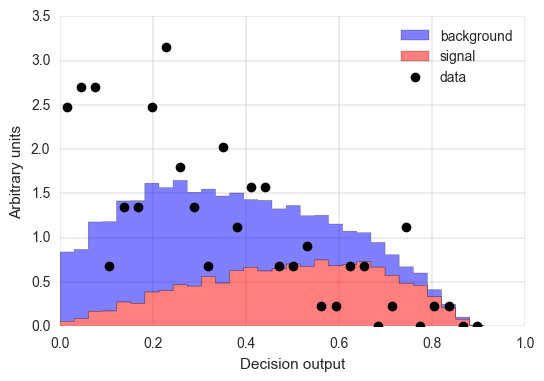

In [61]:
over_training_curve(pipe_classifiers["DNN"], df_X, df_y, X_data)

In [ ]:
df_loaded_model = pd.DataFrame(pipe_classifiers["DNN"].predict_proba(X_data)[:,1], columns=['DNN distribution'])
df_loaded_model.hist(bins=30)

plt.show()

In [53]:
## Prediction score comparison between pipeline model, keras model, and keras classifier model

wall = time.time()
process = time.clock()

#model_json = pipe_classifiers["DNN"].named_steps["kerasclassifier"].model.to_json()
print pipe_classifiers["DNN"].predict_proba(X_data)[0]
scaler.fit(df_X)
Z = scaler.transform(X_data)
print pipe_classifiers["DNN"].named_steps["kerasclassifier"].predict_proba(Z)[0]

print pipe_classifiers["DNN"].named_steps["kerasclassifier"].model.predict_proba(Z)[0]

print "\nTotal wall time of program: ", time.time()-wall
print "Total elapsed process time of program: ", time.clock()-process


[ 0.8116768   0.18832321]


RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)

[ 0.8143028   0.18569723]
 32/146 [=====>........................] - ETA: 0s146/146 [==============================] - 0s     
[ 0.18569723]

Total wall time of program:  0.156993150711
Total elapsed process time of program:  0.17126


In [54]:
## Model persistence: Store DNN modeling

wall = time.time()
process = time.clock()

model_json = pipe_classifiers["DNN"].named_steps["kerasclassifier"].model.to_json()

with open("keras_dnn_model_tensorflow.json", "w") as json_file:
    json_file.write(model_json)
    
    
# serialize weights to HDF5
pipe_classifiers["DNN"].named_steps["kerasclassifier"].model.save_weights("model_weights.h5")
print("Saved model to disk")


print "\nTotal wall time of program: ", time.time()-wall
print "Total elapsed process time of program: ", time.clock()-process



Saved model to disk

Total wall time of program:  0.433526039124
Total elapsed process time of program:  0.234966


In [55]:
# later...

# input file name
filename = 'keras_dnn_model_tensorflow.json'

# load json and create model
json_file = open(filename, 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model_weights.h5")
print("Loaded model from disk")

Loaded model from disk


 32/146 [=====>........................] - ETA: 1s[ 0.18569723]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13733f6d0>]], dtype=object)

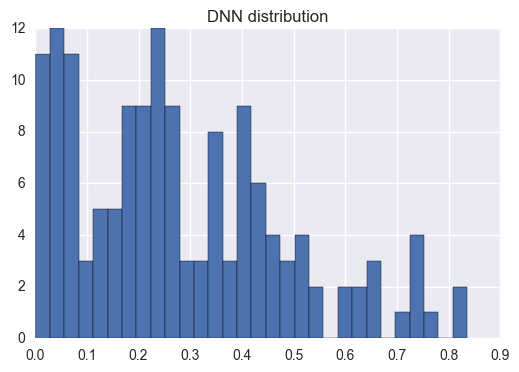

In [56]:
# loaded model prediction scores on unseen data

predict_pos = loaded_model.predict_proba(Z, batch_size=32)
print predict_pos[0]

df_loaded_model =pd.DataFrame(predict_pos, columns=['DNN distribution'])
df_loaded_model.hist(bins=30)

plt.show()

## Deep  Neural Network Model Optimization

In [18]:
## Keras Deep Neural Netork modeling

# split the data
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.33,
                                                    random_state=seed)

# preprocessing using 0-1 scaling byremoving the mean and scaling to unit variance 
scaler = RobustScaler()

# feature selection
select = SelectKBest(k=4)

clf = KerasClassifier(build_fn=create_model, nb_epoch=20, batch_size=2, verbose=0)

steps = [('scaler', scaler),
         ('feature_selection', select),
         ('keras_dnn', clf)]

pipeline = Pipeline(steps)

parameters = dict(feature_selection__k=[12], 
              keras_dnn__dropout_rate=[0.2])

cv = GridSearchCV(pipeline, param_grid=parameters)
cv.fit(X_train, y_train)

y_predictions = cv.predict(X_test)
report = classification_report( y_test, y_predictions )
print report

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('feature_selection', SelectKBest(k=4, score_func=<function f_classif at 0x11e012398>)), ('keras_dnn', <keras.wrappers.scikit_learn.KerasClassifier object at 0x128cd7910>)]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'feature_selection__k': [12], 'keras_dnn__dropout_rate': [0.2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

             precision    recall  f1-score   support

        0.0       0.72      0.79      0.75      2224
        1.0       0.64      0.54      0.59      1528

avg / total       0.69      0.69      0.69      3752



In [23]:
# Default pipeline setup with dummy place holder steps
pipe = Pipeline([('feature_scaling', None), 
                 ('feature_selection', None), 
                 ('classifier', DummyClassifier())])

# preprocessing using 0-1 scaling byremoving the mean and scaling to unit variance 
scaler = RobustScaler()

# feature selection
select = SelectKBest(k=4)

# create classifier for use in scikit-learn
model = KerasClassifier(build_fn=create_model, nb_epoch=20, batch_size=2, verbose=0)

# prepare models: create a mapping of ML classifier name to algorithm
param_grid = [
    {'classifier': [model],
     'classifier__dropout_rate': [0.2],
     'feature_selection': [select],
     'feature_selection__k': [12],
     'feature_scaling': [scaler]
    }
]

#pcv = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=2, n_jobs=1)

pcv = GridSearchCV(estimator=pipe, param_grid=param_grid)
pcv.fit(X_train, y_train)

y_pred = pcv.predict(X_test)
report = classification_report( y_test, y_pred )
print report

# LOOK INTO: JSON TO XML converter
# http://stackoverflow.com/questions/28459651/is-there-a-way-to-convert-json-file-to-xml-by-using-groovy-script-on-soapui

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('feature_scaling', None), ('feature_selection', None), ('classifier', DummyClassifier(constant=None, random_state=None, strategy='stratified'))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'feature_selection__k': [12], 'classifier__dropout_rate': [0.2], 'feature_selection': [SelectKBest(k=12, score_func=<function f_classif at 0x11e012398>)], 'classifier': [<keras.wrappers.scikit_learn.KerasClassifier object at 0x12e045710>], 'feature_scaling': [RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

             precision    recall  f1-score   support

        0.0       0.71      0.77      0.74      2224
        1.0       0.62      0.55      0.58      1528

avg / total       0.68      0.68      0.68      3752



In [27]:

print("Pipeline steps:\n{}".format(pipe.steps))
# extract the first step 
components = pipe.named_steps["feature_scaling"]
print("components: {}".format(components))
classifier = pcv.best_estimator_.named_steps["classifier"]
print("Keras DNN classifier step:\n{}".format(classifier))
print("Best cross-validation accuracy: {:.2f}".format(pcv.best_score_)) 
print("Test set score: {:.2f}".format(pcv.score(X_test, y_test))) 
print("Best parameters: {}".format(pcv.best_params_))


Pipeline steps:
[('feature_scaling', None), ('feature_selection', None), ('classifier', DummyClassifier(constant=None, random_state=None, strategy='stratified'))]
components: None
Keras DNN classifier step:
Best cross-validation accuracy: 0.68
Test set score: 0.68
Best parameters: {'feature_scaling': RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True), 'classifier__dropout_rate': 0.2, 'feature_selection': SelectKBest(k=12, score_func=<function f_classif at 0x11e012398>), 'classifier': <keras.wrappers.scikit_learn.KerasClassifier object at 0x12e045710>, 'feature_selection__k': 12}


('W shape : ', (12, 12))


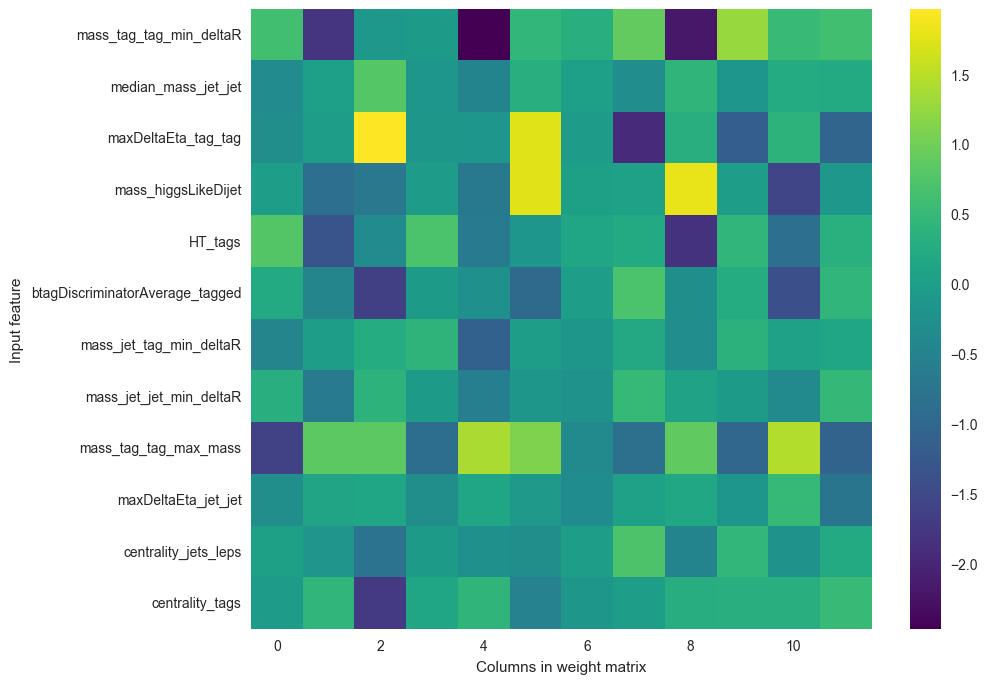

In [31]:
dnn_weight_map(pcv.best_estimator_.named_steps['classifier'])

In [57]:
 # tuning the following design parameters in our neural networks:
# - The number of hidden layers.
# - The number of neurons per hidden layer.
# - The level of dropout.
# - The learning rate to use with the ADAM optimizer [3].
# - The L1 weight penalty.
# - The L2 weight penalty.

# grid search dropout rate, epochs, batch size, and optimizer
#dropout_rate = [0.2] # [0.0, 0.2, 0.5]
#optimizers = ['adam'] # ['rmsprop', 'adam']
#init = ['uniform'] # ['glorot_uniform', 'normal', 'uniform']
#epochs = np.array([50]) # [50, 100, 150]
#batches = np.array([5])  # [5, 10, 20]

#param_grid = dict(dropout_rate=dropout_rate, optimizer=optimizers,
#                  nb_epoch=epochs, batch_size=batches, init=init)

#pipe_param_grid = {'kerasclassifier__dropout_rate': [0.2]#,
                   #'kerasclassifier__optimizers': ['adam'],
                   #'kerasclassifier__init': ['uniform'],
                   #'kerasclassifier__epochs': np.array([50]),
                   #'kerasclassifier__batches': np.array([5]) 
#                  }
